<a href="https://colab.research.google.com/github/ChJazhiel/HPC_II/blob/main/Taller%20GANs/DCGAN_Simpson_Kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generación de personajes de los Simpson con una DCGAN  

**Dataset**  
El conjunto de datos original se puede encontrar en [https://www.kaggle.com/datasets/kostastokis/simpsons-faces](https://www.kaggle.com/datasets/kostastokis/simpsons-faces)  
El archivo consta de 9877 imágenes de 200x200 pixeles de rostros de personajes de los Simpson
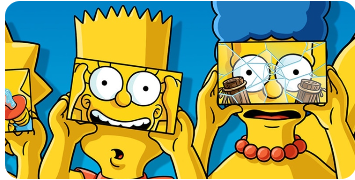

In [ ]:
# Instalar kaggle
!pip install -q kaggle

In [ ]:
# Generar nueva carpeta "kaggle"
!mkdir -p ~/.kaggle

Subir archivo kaggle.json que es el APIToken.  
Para más información como usar la API de Kaggle con Google Colab para cargar y descargar datasets ver
[Cargar y descargar datos de Kaggle](https://platzi.com/tutoriales/1794-pandas/6926-usando-la-api-de-kaggle-con-google-colab-para-carga-y-descarga-de-datasets/)  


In [ ]:
# Cambiar de ruta el archivo a la carpeta kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d kostastokis/simpsons-faces

 99% 439M/442M [00:13<00:00, 38.2MB/s]
100% 442M/442M [00:13<00:00, 33.3MB/s]


In [ ]:
!unzip -q simpsons-faces.zip

In [ ]:
# Importar librerías
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import cv2
import imageio
import glob
import zipfile
from PIL import Image
from pathlib import Path
from IPython import display
from tqdm.auto import tqdm # Loading bar

# Importar paquetes de pytorch
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F

# Importar paquetes de  torchvision packages
from torchvision import datasets
from torchvision import transforms

In [ ]:
image_path = "content/cropped/"

In [ ]:
# Obtener lista de imágenes en la carpeta
images = Path("/content/cropped").glob("*.png")
image_strings = [str(p) for p in images]
print(f"Número de imágenes en la carpeta: {len(image_strings)}")

Número de imágenes en la carpeta: 9877


Ruta de la imagen aleatoria: /content/cropped/198.png
Tamaño de la imagen: 200 x 200
Número de canales: ('R', 'G', 'B')


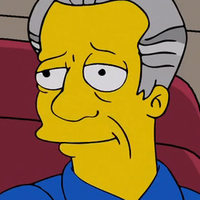

In [ ]:
# Selección de una imagen aleatoria de la carpeta y visualizarla
random_image_path = random.choice(image_strings)
img = Image.open(random_image_path)

# Desplegar Metadata y visualizar imagen
print(f"Ruta de la imagen aleatoria: {random_image_path}")
print(f"Tamaño de la imagen: {img.height} x {img.width}")
print(f"Número de canales: {img.getbands()}")
img

## 2. Cargar conjunto de datos en el formato de PyTorch  

In [ ]:
# Escribir las transformaciones para preparar a las imágenes
data_transform = transforms.Compose([transforms.Resize(size=(64, 64)),
                                    transforms.ToTensor()])

Información de las imágenes
-----------------------------------------------------------
Tamaño de la imagen original: (200, 200, 3)
Rango[min:0, max: 246]
-----------------------------------------------------------
Tamaño de la imagen transformada: torch.Size([64, 64, 3])
Rango[min: 0.0, max: 0.8823529481887817]




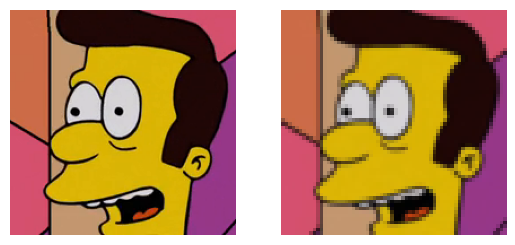

In [ ]:
# Selección de una imagen aleatoria de la carpeta
random_image_path = random.choice(image_strings)
img = Image.open(random_image_path)
# Transformación de la imagen
transformed_image = data_transform(img).permute(1, 2, 0) # Para visualizar la imagen,se modifica el tensor con forma (C,H,W) a (H,W,C)

## Información de las imágenes
print("Información de las imágenes")
print("-----------------------------------------------------------")
## ------ Imágen original ------
arr_img = np.asarray(img)
print(f"Tamaño de la imagen original: {arr_img.shape}")
print(f"Rango[min:{arr_img.min()}, max: {arr_img.max()}]")
print("-----------------------------------------------------------")
## ------ Imágen transformada ------
print(f"Tamaño de la imagen transformada: {transformed_image.shape}")
print(f"Rango[min: {transformed_image.min()}, max: {transformed_image.max()}]")
print("\n")

# Visualizar imagen original y tranformación
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img)
ax[0].axis("off")

ax[1].imshow(transformed_image)
ax[1].axis("off")
plt.show()

#### Cagar el conjunto de datos con la clase Dataset

In [ ]:
class CustomDataset(Dataset):
    def __init__(self,img_path,transform=None):
        self.img_path = img_path
        self.data = glob.glob(self.img_path + "*")
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self,idx):
        img_path = self.data[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        if self.transform:
            image = self.transform(image)
        return image

In [ ]:
train_dataset = CustomDataset('./cropped/',transform=data_transform)
print(f"Tamaño del Dataset: {len(train_dataset)}")

Tamaño del Dataset: 9877


In [ ]:
# DataLoader is used to load the dataset for training
BATCH_SIZE = 64
train_dataloader = DataLoader(dataset = train_dataset,
                               batch_size = BATCH_SIZE,# Número de muestras que contiene cada batch
                               shuffle = True)

In [ ]:
print(f"Número de batches en el train loader: {len(train_dataloader)} batches de {BATCH_SIZE} imágenes cada uno")

Número de batches en el train loader: 155 batches de 64 imágenes cada uno


In [ ]:
# Verificar que hay dentro del DataLoader
train_batches = next(iter(train_dataloader))
print(train_batches.shape)

torch.Size([64, 3, 64, 64])


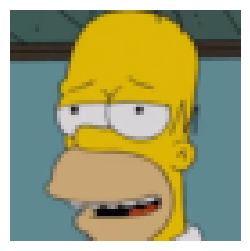

In [ ]:
# Visualizar una imagen aleatoria del batch
random_idx = random.randint(0, len(train_batches)-1)
img_batch = train_batches[random_idx]
fig = plt.figure(figsize=(3,3))
plt.imshow(img_batch.squeeze().permute(1, 2, 0))
plt.axis("off")
plt.show()

In [ ]:
# Configuración de CPU o GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")

Device: cuda



## 4. Definir modelos

#### Discriminador

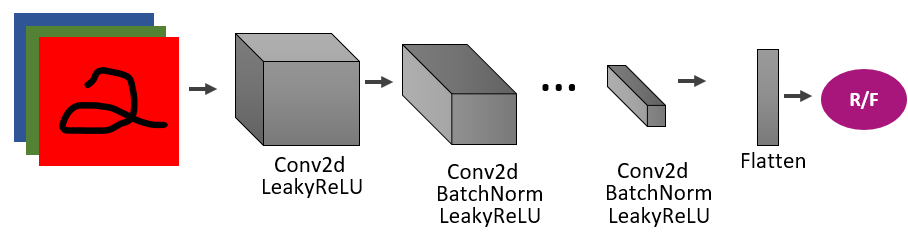

In [ ]:
# Discriminator Model Class Definition
class Discriminator(nn.Module):
    def __init__(self, channels_img, hidden_units):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=channels_img, out_channels=hidden_units, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units*2, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(hidden_units*2),
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=hidden_units*2, out_channels=hidden_units*4, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(hidden_units*4),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(in_features=16384, out_features=1),
            nn.Sigmoid()
        )

    def forward(self,x):
        x = self.model(x)
        return x

In [ ]:
# Configurar el modelo con los parámetros de entrada
discriminator = Discriminator(channels_img=3, hidden_units=64)
discriminator.to(device)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=16384, out_features=1, bias=True)
    (10): Sigmoid()
  )
)

In [ ]:
# Probar discriminador con entrada dummy
dummy_x = torch.rand([1,3,64,64]).to(device)
print(f"Tamaño del vector de entrada del discriminador: {dummy_x.size()}")

dummy_out = discriminator(dummy_x).detach()
print(f"Salida del discriminador: {dummy_out}")

Tamaño del vector de entrada del discriminador: torch.Size([1, 3, 64, 64])
Salida del discriminador: tensor([[0.4323]], device='cuda:0')


#### Generador
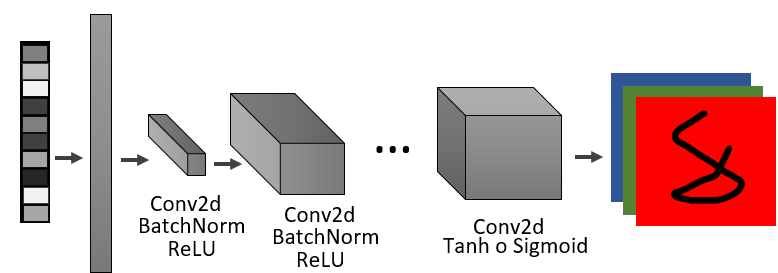

In [ ]:
# Generator Model Class Definition
class Generator(nn.Module):
    def __init__(self, latent_dim, hidden_units):
        super().__init__()
        self.hidden_units = hidden_units
        self.block1 = nn.Sequential(
            nn.Linear(in_features=latent_dim, out_features=16*16*hidden_units*4))
        self.block2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=hidden_units*4, out_channels=hidden_units*2, kernel_size=3, stride=2, padding=1,output_padding=1),
            nn.BatchNorm2d(hidden_units*2),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(in_channels=hidden_units*2, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(hidden_units),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(in_channels=hidden_units, out_channels=3,  kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self,x):
        x = self.block1(x)
        # reshape from flatten to 7*7*hidden_units
        x = torch.reshape(x, (-1, self.hidden_units*4,16,16))
        x = self.block2(x)
        return x

In [ ]:
LATENT_DIM = 128

In [ ]:
# Configurar el modelo con los parámetros de entrada
generator = Generator(latent_dim=LATENT_DIM, hidden_units=64)
generator.to(device)

Generator(
  (block1): Sequential(
    (0): Linear(in_features=128, out_features=65536, bias=True)
  )
  (block2): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): ConvTranspose2d(64, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (7): Sigmoid()
  )
)

In [ ]:
# Probar generador con entrada dummy
dummy_x = torch.rand([1,LATENT_DIM]).to(device)
print(f"Tamaño del vector de entrada del generador: {dummy_x.size()}")

dummy_img = generator(dummy_x).cpu().detach()
print(f"Tamaño de la salida del generador: {dummy_img.shape}")

Tamaño del vector de entrada del generador: torch.Size([1, 128])
Tamaño de la salida del generador: torch.Size([1, 3, 64, 64])


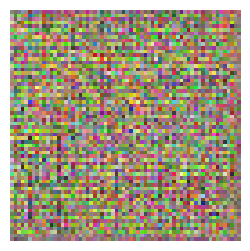

In [ ]:
# Visualizar una imagen
fig = plt.figure(figsize=(3,3))
plt.imshow(dummy_img.squeeze().permute(1, 2, 0))
plt.axis("off")
plt.show()

#### Optimización

In [ ]:
# Definir hiperparámetros del optimizador
lr = 0.0002
betas = (0.5, 0.999)

generator_opt = torch.optim.Adam(params=generator.parameters(), lr=lr, betas=betas)
discriminator_opt = torch.optim.Adam(params=discriminator.parameters(), lr=lr, betas=betas)

#### Función de costo del discriminador

In [ ]:
def discriminator_loss(real_out, fake_out,smoothing_factor = 0.9):
    '''
    Input:
    - real_out. Predicciones de imágenes reales
    - fake_ out. Predicciones de imágenes falsas
    -smoothing_factor. Factor de ruido en la entrada del discriminador
    '''
    real_loss = F.binary_cross_entropy(real_out, torch.ones_like(real_out)*smoothing_factor)
    fake_loss = F.binary_cross_entropy(fake_out, torch.zeros_like(fake_out))
    total_loss = (real_loss + fake_loss)/2
    return total_loss

In [ ]:
def generator_loss(fake_out):
    '''
    Input:
    - fake_ out. Predicciones de imágenes falsas
    '''
    gen_loss = F.binary_cross_entropy(fake_out, torch.ones_like(fake_out))
    return gen_loss

## 5. Entrenamiento

In [ ]:
def generate_noise_vectors(sample_size,latent_dim):
    '''
    Input:
    - sample_size. Tamaño de las muestras
    - latent_dim. Dimesión del vector
    '''
    noise_vector = torch.randn(sample_size,latent_dim)
    return noise_vector

In [ ]:
# Generar vectores para imágenes de prueba
num_images_test = 25
torch.manual_seed(42)
noise_test = generate_noise_vectors(num_images_test,LATENT_DIM)
noise_test.shape

torch.Size([25, 128])

In [ ]:
def show_grid(images, epoch, rows = int(math.sqrt(num_images_test))):
    num = images.size(0)
    fig = plt.figure(figsize= (5,5))

    for i in range(1, num+1):
        fig.add_subplot(rows, rows, i)
        plt.axis('off')
        plt.imshow(images[i-1].squeeze().permute(1, 2, 0))

    plt.savefig('./image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()
    return

In [ ]:
EPOCHS = 80

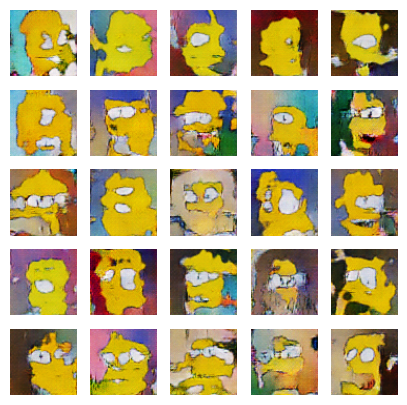

Epoch: 76
--------
Train Epoch: 76 [0/9877 (0%)]	G-Loss: 5.395812 D-Loss: 0.175188
Train Epoch: 76 [6400/9877 (65%)]	G-Loss: 6.090153 D-Loss: 0.173625
Epoch: 77
--------
Train Epoch: 77 [0/9877 (0%)]	G-Loss: 6.226678 D-Loss: 0.168497
Train Epoch: 77 [6400/9877 (65%)]	G-Loss: 5.247029 D-Loss: 0.174413
Epoch: 78
--------
Train Epoch: 78 [0/9877 (0%)]	G-Loss: 5.236872 D-Loss: 0.175433
Train Epoch: 78 [6400/9877 (65%)]	G-Loss: 5.418281 D-Loss: 0.172072
Epoch: 79
--------
Train Epoch: 79 [0/9877 (0%)]	G-Loss: 6.144260 D-Loss: 0.166698
Train Epoch: 79 [6400/9877 (65%)]	G-Loss: 5.756701 D-Loss: 0.165697


In [ ]:
# training mode
generator.train()
discriminator.train()

for epoch in tqdm(range(EPOCHS)):
    print(f"Epoch: {epoch}\n--------" )
    for batch, (real_images) in enumerate(train_dataloader):
        ## ---------------------- Train Discriminator ----------------------
        for i in range(0,2):
            # train the discriminator
            discriminator_opt.zero_grad()
            cur_batch_size = len(real_images)
            real_images = real_images.to(device)
            noise = generate_noise_vectors(cur_batch_size,LATENT_DIM).to(device)
            fake_images = generator(noise)
            # Entrenamiento en datos reales
            real_preds = discriminator(real_images)
            # Entrenamiento en datos falsos
            fake_preds = discriminator(fake_images.detach())
            disc_loss = discriminator_loss(real_preds, fake_preds,0.9)
            disc_loss.backward()
            # Optimizer step
            discriminator_opt.step()

        ## ---------------------- Train Generator ----------------------
        noise = generate_noise_vectors(cur_batch_size,LATENT_DIM).to(device)
        generated_images = generator(noise)
        # train the generator
        generator_opt.zero_grad()
        # Generación de imagenes
        fake_preds = discriminator(generated_images)
        gen_loss = generator_loss(fake_preds)
        gen_loss.backward()
        generator_opt.step()

        if batch % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tG-Loss: {:.6f} D-Loss: {:.6f}'.format(
                epoch, batch * len(real_images), len(train_dataloader.dataset),
                100. * batch / len(train_dataloader), gen_loss.item(), disc_loss.item()))


    #show the test images every 10 epochs
    if epoch%5 ==0:
        display.clear_output(wait=True)
        test_imgs = generator(noise_test.to(device)).detach()
        test_imgs = test_imgs.cpu()
        show_grid(test_imgs,epoch)

In [ ]:
images = list()
filenames = glob.glob('./image*.png')
filenames = sorted(filenames)
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('./dcgan_simpson.gif', images)

<ipython-input-39-45c0622fa92a>:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))
